In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.cluster import KMeans

In [5]:
from sklearn.metrics import silhouette_score

In [6]:
import matplotlib.pyplot as plt

In [7]:
pd.set_option('display.max_columns', 50)

In [8]:
pd.set_option('display.width', 140)

In [9]:
df = pd.read_csv('data/online_retail_II.csv', encoding = 'latin1')

In [10]:
df.shape

(1067371, 8)

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [13]:
df = df.copy()

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors = 'coerce')

In [15]:
df = df.dropna(subset=['InvoiceDate']).copy()

In [63]:
df = df.dropna(subset =['Customer ID']).copy()

In [64]:
df.loc[:, "Customer ID"] = df["Customer ID"].astype(int)

In [65]:
df['Quantity'] = pd.to_numeric(df['Quantity'], errors ='coerce')

In [66]:
df['Price'] = pd.to_numeric(df['Price'], errors ='coerce')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 61.5+ MB


In [19]:
df = df[(df['Quantity'] > 0 ) & (df['Price'] > 0 )].copy()

In [20]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [21]:
df.shape

(805549, 9)

In [22]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [23]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days = 1)

In [25]:
rfm = (
    df.groupby('Customer ID').agg(
        Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
        Frequency = ('Invoice','nunique'),
        Monetary = ('TotalPrice', 'sum')
        
    )
    .reset_index()
)

In [26]:
rfm.shape

(5878, 4)

In [27]:
display(rfm.head())

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [28]:
display(rfm.describe())

,Customer ID,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,201.331916,6.289384,3018.616737
std,1715.572666,209.338707,13.009406,14737.731040
min,12346.000000,1.000000,1.000000,2.950000
25%,13833.250000,26.000000,1.000000,348.762500
50%,15314.500000,96.000000,3.000000,898.915000
75%,16797.750000,380.000000,7.000000,2307.090000
max,18287.000000,739.000000,398.000000,608821.650000


In [30]:
rfm_clipped = rfm.copy()

In [68]:
for col in ['Recency', 'Frequency', 'Monetary']:
    q1= rfm_clipped[col].quantile(0.25)
    q3= rfm_clipped[col].quantile(0.75)
    iqr = q3-q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    rfm_clipped[col] = rfm_clipped[col].clip(low,high)
    

In [34]:
display(rfm_clipped.describe())

,Customer ID,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,201.257741,5.785471,2353.102019
std,1715.572666,209.151082,7.630332,4338.144850
min,12346.000000,1.000000,1.000000,46.846500
25%,13833.250000,26.000000,1.000000,348.762500
50%,15314.500000,96.000000,3.000000,898.915000
75%,16797.750000,380.000000,7.000000,2307.090000
max,18287.000000,726.000000,46.000000,29730.420200


In [37]:
features = ['Recency', 'Frequency', 'Monetary']

In [38]:
X = rfm_clipped[features].values

In [40]:
scaler = StandardScaler()

In [43]:
X_scaled = scaler.fit_transform(X)

In [44]:
X_scaled[:3]

array([[ 0.59647251,  0.81451995,  6.31137231],
       [-0.95277868,  0.29025175,  0.75619813],
       [-0.603719  , -0.1029494 , -0.07692929]])

In [45]:
inertias = []

In [46]:
sil_scores = []

In [47]:
k_values = range(2,11)

In [48]:
for k in k_values:
    km = KMeans(n_clusters = k, random_state=42, n_init ='auto')
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled,labels))

In [49]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

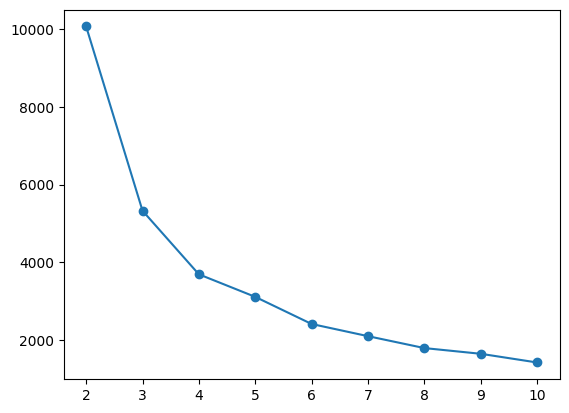

In [50]:
plt.plot(list(k_values), inertias, marker='o')

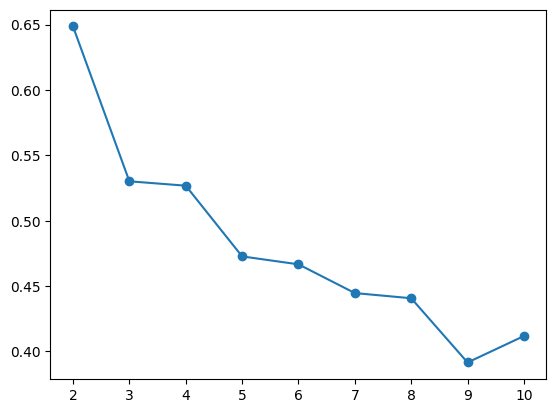

In [51]:
plt.plot(list(k_values), sil_scores,marker = 'o')

In [52]:
best_k = 4

In [54]:
kmeans = KMeans(n_clusters = best_k, random_state=42, n_init = 'auto')

In [55]:
rfm_clipped['Segment'] = kmeans.fit_predict(X_scaled)

In [56]:
rfm_clipped.head()

,Customer ID,Recency,Frequency,Monetary,Segment
0,12346.0,326,12,29730.4202,2
1,12347.0,2,8,5633.3200,1
2,12348.0,75,5,2019.4000,0
3,12349.0,19,4,4428.6900,0
4,12350.0,310,1,334.4000,3


In [58]:
segment_summary = (
    rfm_clipped.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].agg(['mean','median', 'count'])
    .sort_values(('Monetary', 'mean'), ascending=False)

)

In [69]:
rfm_clipped['Segment'].value_counts()

Segment
0    3023
3    1872
1     796
2     187
Name: count, dtype: int64

In [70]:
segment_summary

Recency               Frequency                   Monetary                 
               mean median count       mean median count          mean     median count
Segment                                                                                
2         38.208556    8.0   187  34.962567   37.0   187  21217.053111  21373.970   187
1         43.709799   23.0   796  15.133166   13.0   796   6167.121388   5394.465   796
0         83.508766   57.0  3023   3.833940    3.0  3023   1222.862411    924.320  3023
3        474.683761  437.0  1872   2.047543    1.0  1872    672.117012    373.095  1872